In [1]:
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt


from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.utils import to_categorical

from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD

from keras.layers import UpSampling2D
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def load_mnist_data():
    """ load mnist data """
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.astype(np.float32) / 255.
    X_test = X_test.astype(np.float32) / 255.
    X_train = X_train[:,:,:,None]
    X_test = X_test[:,:,:,None]

    X_test_original = X_test.copy()

    #X_train = X_train[Y_train==0]
    #X_test = X_test[Y_test==0]
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    print('train shape: ', X_train.shape)
    print('X_test_original shape: ', X_test_original.shape)
    print('y_train shape: ', y_train.shape)

    return X_train, X_test, X_test_original, y_train, y_test

In [3]:
X_train, X_test, X_test_original, y_train, y_test = load_mnist_data()

train shape:  (60000, 28, 28, 1)
X_test_original shape:  (10000, 28, 28, 1)
y_train shape:  (60000, 10)


In [4]:
X_ruined = X_train[:1000].copy()
y_ruined = X_train[:1000].copy()
print(X_ruined.shape)
print(y_ruined.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [5]:
#X_ruined[:,12,5:20] = 1
#X_ruined[:,1:20,5:10] = 1

# noise range
rn = 5

# 랜덤 깨진 MNISt 만들기 
for i in range(0, X_ruined.shape[0]) : 
    ix = np.random.randint(0, X_ruined.shape[1]-rn)
    iz = np.random.randint(0, X_ruined.shape[1]-rn)
    ic = np.random.randint(0, X_ruined.shape[1]-rn)
    X_ruined[i, 10:20, ix:ix+rn] = 1.
    X_ruined[i, iz:iz+rn , 5:14] = 1.
    X_ruined[i, ic:ic+rn , ic:ic+rn] = 1.

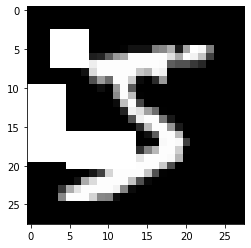

In [6]:
plt.imshow(X_ruined[0].reshape((28,28)), cmap='gray')

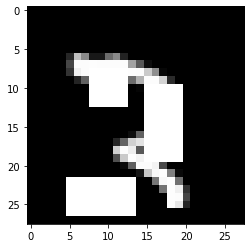

In [7]:
plt.imshow(X_ruined[500].reshape((28,28)), cmap='gray')

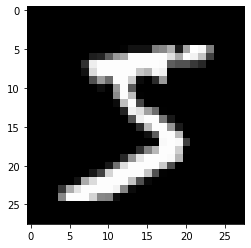

In [8]:
plt.imshow(y_ruined[0].reshape((28,28)), cmap='gray')

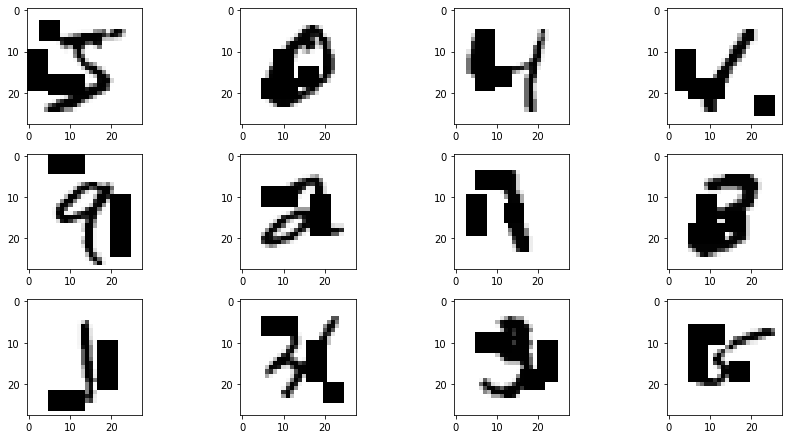

In [9]:
count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(12):
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(X_ruined[n].reshape(28, 28), cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show()

모델 정의

In [10]:
#input_size=(256,256,3)
def unet(input_size):
    inputs = Input(input_size)
    depth = 32
    depth1 = depth * 1
    depth2 = depth * 2
    depth3 = depth * 4
    conv1 = Conv2D(depth1, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth1, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    print("conv1",conv1)
    
    conv2 = Conv2D(depth2, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth2, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    print("conv2",conv2)
    
    conv3 = Conv2D(depth3, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth3, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    print("conv3",conv3)
    
    up8 = concatenate([Conv2DTranspose(depth2, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv8 = Conv2D(depth2, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(depth2, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    print("conv8",conv8)
    
    up9 = concatenate([Conv2DTranspose(depth1, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(depth1, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(depth1, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    print("conv9",conv9)
    
    #conv10=  Flatten()(conv9)
    #conv11 = Dense(128)(conv10)
    #conv12 = Dropout(0.5)(conv11)

    #conv13= Dense(10, activation='softmax')(conv12)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print("conv10",conv10)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])
    
    return model

In [11]:
# 모델 생성
input_size = (28,28,1)
model = unet(input_size)
model.summary()

# 모델 컴파일
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # TODO : remove
#model.compile(loss="mse", optimizer="Adam", metrics=['accuracy'])
#model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])
#
#model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])

print(X_ruined.shape)
print(y_train.shape)
# 학습
hist = model.fit(X_ruined,y_ruined, validation_split=0.2, epochs=10, batch_size=1, verbose=1)

# 모델 저장
model.save('./saved_model/unet.h5')

conv1 Tensor("batch_normalization_2/cond/Identity:0", shape=(None, 28, 28, 32), dtype=float32)
conv2 Tensor("batch_normalization_4/cond/Identity:0", shape=(None, 14, 14, 64), dtype=float32)
conv3 Tensor("batch_normalization_6/cond/Identity:0", shape=(None, 7, 7, 128), dtype=float32)
conv8 Tensor("batch_normalization_8/cond/Identity:0", shape=(None, 14, 14, 64), dtype=float32)
conv9 Tensor("batch_normalization_10/cond/Identity:0", shape=(None, 28, 28, 32), dtype=float32)
conv10 Tensor("conv2d_11/Sigmoid:0", shape=(None, 28, 28, 1), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (No

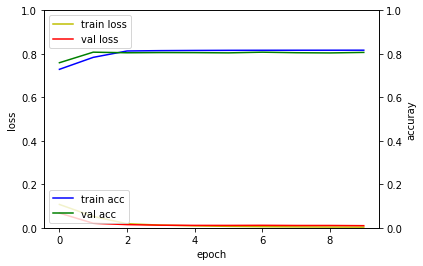

In [12]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [13]:
#이미지 차이 구하고 이미지 채널 바꾸기
def change_channel(image1,image2):
    
    diff = image1 - image2 #차이점 구하기 
    residual_ = diff.reshape((28,28))
    residual_ = np.stack((residual_,)*3, -1) # 3채널로 변경 RGB 형식
    return residual_

In [14]:
def show_rgb(rows, cols, residual_):
    for i in range(rows):
        for j in range(cols):
            for x in range(3):
                if residual_[i,j,x] == 1:
                    if x == 0:
                        residual_[i,j,x] = 1
                    else:
                        residual_[i,j,x] = 0
    
    return residual_

In [15]:
def plotPredictions(model, X_ruined, y_ruined , X_test_ruined, y_test_ruined):

    ix = np.random.randint(0, len(X_ruined))

    input_ = X_ruined[ix:ix+1]
    mask_ = y_ruined[ix:ix+1]
    
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape(28,28),cmap='gray')
    
    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0].reshape(28,28), cmap='gray')
    
    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], cmap='gray')
    
    plt.subplot(1,4,4)
    train_residual_ = change_channel(input_,preds_train_t)
    rows, cols, channels = train_residual_.shape
    train_residual_ = show_rgb(rows,cols,train_residual_)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(train_residual_, cmap='gray')
    plt.show()
    
    # test 데이터 
    ix = np.random.randint(0, len(X_test_ruined))

    input_ = X_test_ruined[ix:ix+1]
    mask_ = y_test_ruined[ix:ix+1]
    
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape(28,28),cmap='gray')
    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0].reshape(28,28), cmap='gray')
    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], cmap='gray')
    
    plt.subplot(1,4,4)
    test_residual_ = change_channel(input_,preds_train_t)
    rows, cols, channels = test_residual_.shape
    test_residual_ = show_rgb(rows,cols,test_residual_)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(test_residual_, cmap='gray')
    plt.show()
    plt.show()

In [16]:
X_test_ruined = X_test[:1000].copy()
y_test_ruined = X_test[:1000].copy()
print(X_test_ruined.shape)

(1000, 28, 28, 1)


In [17]:
#X_test_ruined[:,12,5:20] = 1
#X_test_ruined[:,1:20,5:10] = 1

# 랜덤 깨진 MNISt 만들기 
for i in range(0, X_test_ruined.shape[0]) : 
    ix = np.random.randint(0, X_test_ruined.shape[1]-rn)
    iz = np.random.randint(0, X_test_ruined.shape[1]-rn)
    ic = np.random.randint(0, X_test_ruined.shape[1]-rn)
    X_test_ruined[i, 10:20, ix:ix+rn] = 1.
    X_test_ruined[i, iz:iz+rn , 5:14] = 1.
    X_test_ruined[i, ic:ic+rn , ic:ic+rn] = 1.

1/1 [==============================] - 0s 211ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


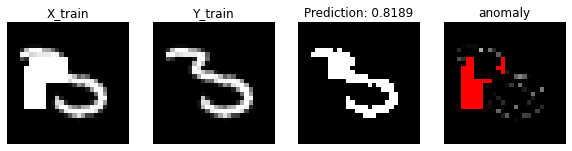

1/1 [==============================] - 0s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


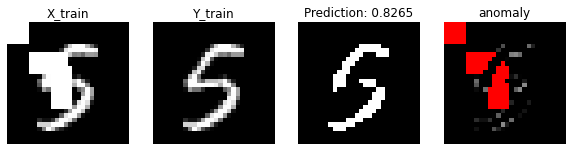

In [18]:
unet_model = load_model('./saved_model/unet.h5')
plotPredictions(unet_model, X_ruined,y_ruined, X_test_ruined, y_test_ruined)